In [1]:
# # 从数据库中读取数据包
from pyspark.sql import SparkSession
import os
from pytoolkit import TDWSQLProvider
import pandas

In [2]:
# 连接spark,这个只允许运行一次，再次运行需要重启内核
os.environ['GROUP_ID'] = 'g_wxg_wxt_product_analytics_intern'
os.environ['GAIA_ID'] = '5729'
session = SparkSession.builder.config('spark.driver.maxResultSize','14g').config('spark.driver.memory', '14g').config('spark.executor.cores', 4).config('spark.executor.memory', '14g').config('spark.yarn.archive','hdfs://qy-ieg-4-v2/data/SPARK/cachefile/3_12_2.4.6_hadoop3/spark-jars_old_notauth.zip').getOrCreate()
# session = SparkSession.builder.config('spark.driver.memory', '8g').config('spark.executor.cores', 4).config('spark.executor.memory', '8g').getOrCreate()

Driver Log: b8872aef-0f3f-40d6-9d4e-052f5fd53fb8.log
Tracking URL: http://application.tdw.oa.com:8080/proxy/application_1666389614065_1094480


In [ ]:
# 若数据量小，可以直接读取
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_weixin_analytics_intern')
df=provider.table('tmp_dws_app_bilateral_expt_11141246_user_intern_uin_i').toPandas()

In [3]:
# 若数据量较大，分不同的sql读取
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_weixin_analytics_intern')
tbl=provider.table('tmp_dws_app_bilateral_expt_11141246_user_intern_uin_i')
tbl.createOrReplaceTempView('tbl')

In [4]:
df_head=session.sql('select * from tbl limit 5').toPandas()
df_head

,ds,groupid,first_hit_ds,is_active_today,stay_cnt,like_svr_cnt,follow_svr_cnt,forward_cnt,cold_start_stay_cnt,stay_time,anonymous
0,20220328,253814,20220402,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,cf5d25623e771b880a3262f43f18dbe5
1,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,893622d1e54504eeb0a3fec7e1d52e62
2,20220328,253814,20220331,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,a4806c2a63f1c233a47ca06528ab4f24
3,20220328,253814,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,ba3310215cb7e1fa4f0d9e575475e4fd
4,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,a523b49b164aa930e07041bfbb910096


In [5]:
#数据分析包
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# 
from metric_funcs import Ttest, Metric
from frt_pvalue import sharp_null_hypothesis_pvalue

# EDA_user_side

## 1. initial data exploration

In [8]:
# 1.check data
df_head

,ds,groupid,first_hit_ds,is_active_today,stay_cnt,like_svr_cnt,follow_svr_cnt,forward_cnt,cold_start_stay_cnt,stay_time,anonymous
0,20220328,253814,20220402,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,cf5d25623e771b880a3262f43f18dbe5
1,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,893622d1e54504eeb0a3fec7e1d52e62
2,20220328,253814,20220331,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,a4806c2a63f1c233a47ca06528ab4f24
3,20220328,253814,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,ba3310215cb7e1fa4f0d9e575475e4fd
4,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,a523b49b164aa930e07041bfbb910096


In [9]:
# 2.check columns
df_head.dtypes

ds                       int64
groupid                  int64
first_hit_ds             int64
is_active_today        float64
stay_cnt               float64
like_svr_cnt           float64
follow_svr_cnt         float64
forward_cnt            float64
cold_start_stay_cnt    float64
stay_time              float64
anonymous               object
dtype: object

### context：冷启保量100vv 

context：改变冷启的召回的参数:
1. numerical variable： 
stay_cnt: user当天看了多少条feed
cold_start_stay_cnt:user当天看了多少条冷启feed
like_svr_cnt:user当天的点赞数
follow_svr_cnt:user当天的follow数
forward_cnt:user当天的转发数 
stay_time:当天的停留时长

2. catgorical variable:
is_active_today: bool型变量（True活跃，False不活跃） 
anonymous: user nuique id
ds: date（日期）
first_hit_ds: 首次命中的日期
group_id: 是哪个实验组

In [7]:
numerical_col=["stay_cnt","cold_start_stay_cnt","like_svr_cnt","follow_svr_cnt","forward_cnt","stay_time"]
categorical_col=["anonymous","ds","first_hit_ds","groupid","is_active_today"]

## 2. Univariate Aanlysis

### 2.1 orginal data

### 2.2 try to restore real data

#### restore numerical variable

In [6]:
# copy data
df=session.sql('select ds,groupid,stay_cnt from tbl where ds> first_hit_ds').toPandas()
df.head(5)

,ds,groupid,stay_cnt
0,20220328,253815,2.959817
1,20220328,253814,2.959817
2,20220328,253815,2.959817
3,20220328,253814,593.975882
4,20220328,253816,2.959817


they did: AX + B (A and B are random value)
1.X=0; AX+B=B
2.X=1;AX+B = A+B

In [7]:
# (1) -min (suppose min= 0)
print(np.sort(df["stay_cnt"].unique())[0:2])

[2.95981725 7.33771403]


In [8]:
B= np.sort(df["stay_cnt"].unique())[0]
A= np.sort(df["stay_cnt"].unique())[1]-np.sort(df["stay_cnt"].unique())[0]
print("stay_cnt",B,A)
df["stay_cnt"]=(df["stay_cnt"]-B)/A
print("stay_cnt",np.sort(df["stay_cnt"].unique())[0:2])

stay_cnt 2.959817249436907 4.377896778541956
stay_cnt [0. 1.]


In [9]:
# check new data
print(np.sort(df["stay_cnt"].unique())[0:15])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [10]:
np.round(df.groupby(df["ds"]).mean(),3)

,groupid,stay_cnt
ds,,
20220326,253815.000,26.508
20220327,253815.001,18.287
20220328,253815.001,14.765
20220329,253815.001,14.267
20220330,253815.001,13.880
20220331,253815.001,13.622
20220401,253815.001,13.568
20220402,253815.001,12.795


In [11]:
np.round(df.groupby(df["groupid"]).mean(),3)

,ds,stay_cnt
groupid,,
253814,2.022035e+07,15.070
253815,2.022035e+07,15.017
253816,2.022035e+07,15.134


In [12]:
####
df=session.sql('select ds,groupid,cold_start_stay_cnt from tbl where ds> first_hit_ds').toPandas()
df.head(5)

,ds,groupid,cold_start_stay_cnt
0,20220328,253815,7.390883
1,20220328,253814,7.390883
2,20220328,253815,7.390883
3,20220328,253814,7.390883
4,20220328,253816,7.390883


In [13]:
# (1) -min (suppose min= 0)
print(np.sort(df["cold_start_stay_cnt"].unique())[0:2])

[ 7.39088313 15.93872222]


In [14]:
B= np.sort(df["cold_start_stay_cnt"].unique())[0]
A= np.sort(df["cold_start_stay_cnt"].unique())[1]-np.sort(df["cold_start_stay_cnt"].unique())[0]
print("cold_start_stay_cnt",B,A)
df["cold_start_stay_cnt"]=(df["cold_start_stay_cnt"]-B)/A
print("cold_start_stay_cnt",np.sort(df["cold_start_stay_cnt"].unique())[0:2])

cold_start_stay_cnt 7.390883125100945 8.547839090844223
cold_start_stay_cnt [0. 1.]


In [16]:
# check new data
print(np.sort(df["cold_start_stay_cnt"].unique())[0:15])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [18]:
np.round(df.groupby(df["groupid"]).mean(),3)

,ds,cold_start_stay_cnt
groupid,,
253814,2.022035e+07,0.226
253815,2.022035e+07,0.246
253816,2.022035e+07,0.288


In [19]:
####
df=session.sql('select ds,groupid,like_svr_cnt from tbl where ds> first_hit_ds').toPandas()
df.head(5)

,ds,groupid,like_svr_cnt
0,20220328,253815,3.259428
1,20220328,253814,3.259428
2,20220328,253815,3.259428
3,20220328,253814,396.940187
4,20220328,253816,3.259428


In [20]:
# (1) -min (suppose min= 0)
print(np.sort(df["like_svr_cnt"].unique())[0:2])
B= np.sort(df["like_svr_cnt"].unique())[0]
A= np.sort(df["like_svr_cnt"].unique())[1]-np.sort(df["like_svr_cnt"].unique())[0]
print("like_svr_cnt",B,A)
df["like_svr_cnt"]=(df["like_svr_cnt"]-B)/A
print("like_svr_cnt",np.sort(df["like_svr_cnt"].unique())[0:2])
# check new data
print(np.sort(df["like_svr_cnt"].unique())[0:15])

[ 3.25942828 11.13304347]
like_svr_cnt 3.25942828482793 7.873615180670338
like_svr_cnt [0. 1.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [21]:
np.round(df.groupby(df["groupid"]).mean(),3)

,ds,like_svr_cnt
groupid,,
253814,2.022035e+07,0.163
253815,2.022035e+07,0.164
253816,2.022035e+07,0.162


In [22]:
####
df=session.sql('select ds,groupid,stay_cnt,cold_start_stay_cnt,like_svr_cnt from tbl where ds> first_hit_ds').toPandas()
df.head(5)

,ds,groupid,stay_cnt,cold_start_stay_cnt,like_svr_cnt
0,20220328,253815,2.959817,7.390883,3.259428
1,20220328,253814,2.959817,7.390883,3.259428
2,20220328,253815,2.959817,7.390883,3.259428
3,20220328,253814,593.975882,7.390883,396.940187
4,20220328,253816,2.959817,7.390883,3.259428


#### restore categorical variable

In [15]:
# check is_active_today
np.sort(df["is_active_today"].unique())

array([ 3.49033122, 11.57288985])

In [16]:
np.sort(new_df["is_active_today"].unique())

array([ 3.49033122, 11.57288985])

In [17]:
new_df["is_active_today"].value_counts()

3.490331     1292248
11.572890     528826
Name: is_active_today, dtype: int64

In [18]:
new_df["is_active_today"]= np.where(new_df["is_active_today"]==new_df.loc[1,"is_active_today"],1,0)

In [19]:
new_df["is_active_today"].value_counts()

0    1292248
1     528826
Name: is_active_today, dtype: int64

### 2.3 clearning data

In [20]:
# check first_hit_ds
new_df["in_experiment"]=np.where(pd.to_numeric(new_df["ds"])>new_df["first_hit_ds"],1,0)

In [21]:
numerical_col=["stay_cnt","cold_start_stay_cnt","like_svr_cnt","follow_svr_cnt","forward_cnt"]
categorical_col=["anonymous","ds","first_hit_ds","groupid","is_active_today","in_experiment"]

### 2.4 univariate analysis

#### statistics analysis

In [22]:
# statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

new_df_output=unistats(new_df)
new_df_output.to_excel("new_univariate_statistics.xls")

In [23]:
new_df_output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,1821074,0,910537,object,False,-,-,-,-,-,-,-,-,-
ds,1821074,0,2,object,False,-,-,-,-,-,-,-,-,-
first_hit_ds,1821074,0,12,int64,True,-,-,-,-,-,-,-,-,-
groupid,1821074,0,2,int64,True,-,-,-,-,-,-,-,-,-
is_active_today,1821074,0,2,int64,True,-,-,-,-,-,-,-,-,-
in_experiment,1821074,0,2,int64,True,-,-,-,-,-,-,-,-,-
stay_cnt,1821074,0,1345,float64,True,11.988874,0.0,0.0,0.0,1.0,2000.0,54.133345,11.027454,199.524849
cold_start_stay_cnt,1821074,0,243,float64,True,0.29789,0.0,0.0,0.0,0.0,1047.0,3.69449,49.881162,6480.320668
like_svr_cnt,1821074,0,51,float64,True,0.14998,0.0,0.0,0.0,0.0,50.0,1.384766,21.111903,592.291414
follow_svr_cnt,1821074,0,50,float64,True,0.01757,0.0,0.0,0.0,0.0,50.0,0.350406,69.45248,7458.645102


In [187]:
# categorical--statistics
for col in categorical_col[1:len(categorical_col)]:
    print(new_df[col].value_counts())

20220718    910537
20220717    910537
Name: ds, dtype: int64
20220707    627412
20220708    256622
20220709    178786
20220710    138172
20220711    114964
20220712     92920
20220713     87850
20220714     78856
20220715     70510
20220716     63494
20220717     57868
20220718     53620
Name: first_hit_ds, dtype: int64
309154    910892
309153    910182
Name: groupid, dtype: int64
0    1292248
1     528826
Name: is_active_today, dtype: int64
1    1738520
0      82554
Name: in_experiment, dtype: int64


#### visualization analysis

array([[<AxesSubplot:title={'center':'groupid'}>,
        <AxesSubplot:title={'center':'first_hit_ds'}>,
        <AxesSubplot:title={'center':'is_active_today'}>],
       [<AxesSubplot:title={'center':'stay_cnt'}>,
        <AxesSubplot:title={'center':'like_svr_cnt'}>,
        <AxesSubplot:title={'center':'follow_svr_cnt'}>],
       [<AxesSubplot:title={'center':'forward_cnt'}>,
        <AxesSubplot:title={'center':'cold_start_stay_cnt'}>,
        <AxesSubplot:title={'center':'in_experiment'}>]], dtype=object)

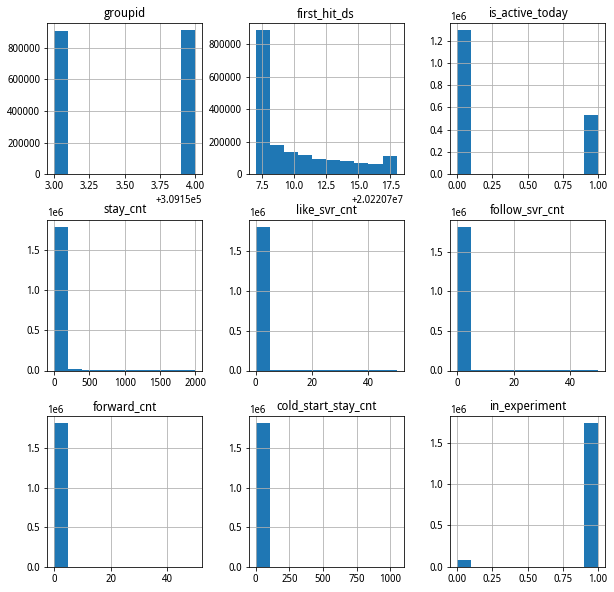

In [188]:
# # Univariate visualization(numerical variable)--histgram
new_df.hist(figsize=(10,10))

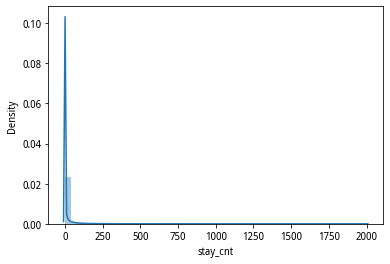

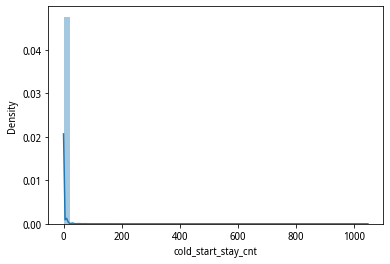

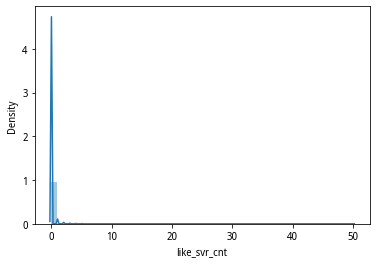

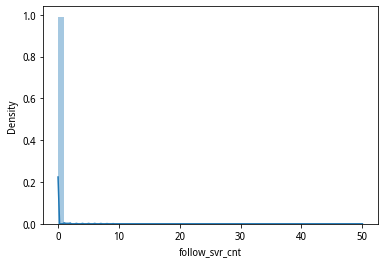

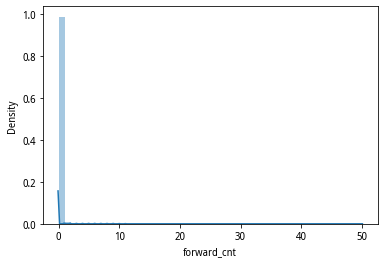

In [138]:
# # Univariate visualization(categorical variable)--brachart
for col in numerical_col:
    sns.distplot(new_df[col])
    plt.show()

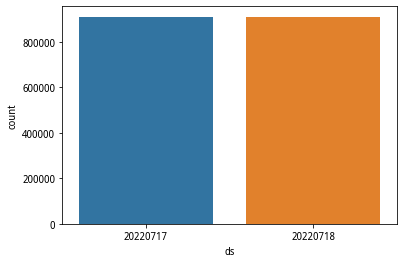

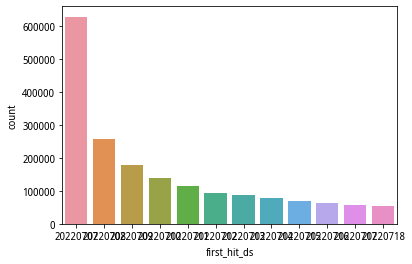

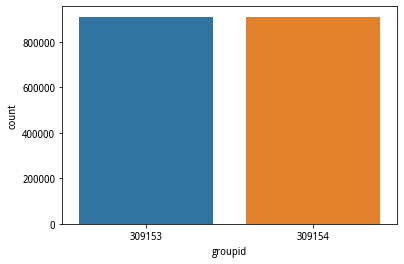

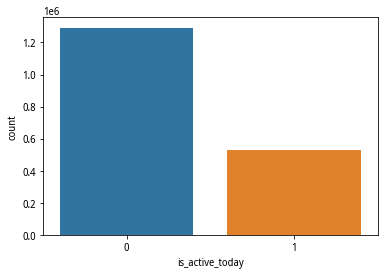

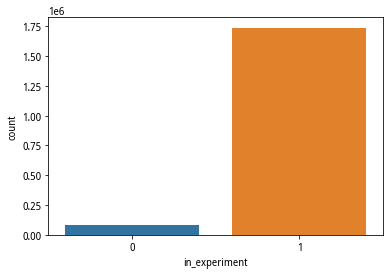

In [190]:
# # Univariate visualization(categorical variable)--brachart
for col in categorical_col[1:len(categorical_col)]:
    sns.countplot(new_df[col])
    plt.show()

conlusion:
1. panel data: individul: 910537, 2-period(0717-0718)
2. first_hit_sd: 12 different days,(20200707--20200718)。wehn ds> first_hit_ds，才参与实验。---需要检查
3. groupid: 309153-control，309154- treatment。
4. is_active_today: inactive number:1292248; active numer:528826, almost 1/3 is active user.
5. for numerical variable: they all highly right skew, a lot of zeros

## 3.Bivariate Analysis

In [24]:
# filter out 没参与实验的user
new_new_df= new_df

In [25]:
new_new_df.drop(new_new_df[new_new_df["in_experiment"]==0].index,inplace=True)

In [26]:
# statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

new_new_df_output=unistats(new_new_df)
new_new_df_output.to_excel("new_new_univariate_statistics.xls")

In [27]:
new_new_df_output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,1738520,0,883727,object,False,-,-,-,-,-,-,-,-,-
ds,1738520,0,2,object,False,-,-,-,-,-,-,-,-,-
first_hit_ds,1738520,0,11,int64,True,-,-,-,-,-,-,-,-,-
groupid,1738520,0,2,int64,True,-,-,-,-,-,-,-,-,-
is_active_today,1738520,0,2,int64,True,-,-,-,-,-,-,-,-,-
in_experiment,1738520,0,1,int64,True,-,-,-,-,-,-,-,-,-
stay_cnt,1738520,0,1344,float64,True,12.139177,0.0,0.0,0.0,1.0,2000.0,54.965231,10.936878,195.522127
cold_start_stay_cnt,1738520,0,243,float64,True,0.306312,0.0,0.0,0.0,0.0,1047.0,3.767845,49.171612,6272.7796
like_svr_cnt,1738520,0,51,float64,True,0.150239,0.0,0.0,0.0,0.0,50.0,1.391008,21.102402,590.592785
follow_svr_cnt,1738520,0,49,float64,True,0.017671,0.0,0.0,0.0,0.0,50.0,0.350887,68.955584,7390.461302


#### (1) numerical- numerical

##### correlation 

In [173]:
# (1) correlation
# # statistics--计算correlation的值
corr_df= pd.DataFrame(columns=["r","p"])
from scipy import stats
for col in numerical_col:
    r,p= stats.pearsonr(new_df[col],new_df["stay_cnt"])
    corr_df.loc[col]=[round(r,3),round(p,3)]
corr_df

,r,p
stay_cnt,1.000,0.0
cold_start_stay_cnt,0.674,0.0
like_svr_cnt,0.277,0.0
follow_svr_cnt,0.165,0.0
forward_cnt,0.200,0.0


In [201]:
np.round(new_new_df[numerical_col].corr(),3)

,stay_cnt,cold_start_stay_cnt,like_svr_cnt,follow_svr_cnt,forward_cnt
stay_cnt,1.000,0.677,0.276,0.165,0.200
cold_start_stay_cnt,0.677,1.000,0.150,0.083,0.099
like_svr_cnt,0.276,0.150,1.000,0.219,0.171
follow_svr_cnt,0.165,0.083,0.219,1.000,0.167
forward_cnt,0.200,0.099,0.171,0.167,1.000


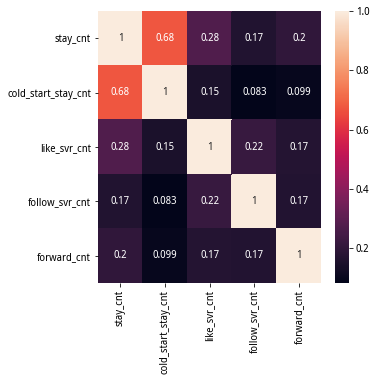

In [202]:
# 画correlation heat map图
plt.figure(figsize=(5,5))
sns.heatmap(np.round(new_new_df[numerical_col].corr(),3),annot=True)
plt.show()

##### visualization--scatterplot

<AxesSubplot:xlabel='stay_cnt', ylabel='cold_start_stay_cnt'>

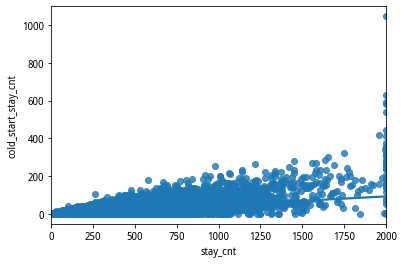

In [205]:
sns.regplot(new_new_df[numerical_col[0]],new_new_df[numerical_col[1]])

<AxesSubplot:xlabel='stay_cnt', ylabel='like_svr_cnt'>

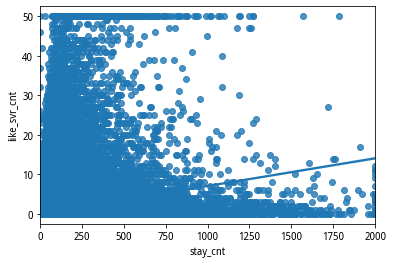

In [206]:
sns.regplot(new_new_df[numerical_col[0]],new_new_df[numerical_col[2]])

<AxesSubplot:xlabel='stay_cnt', ylabel='follow_svr_cnt'>

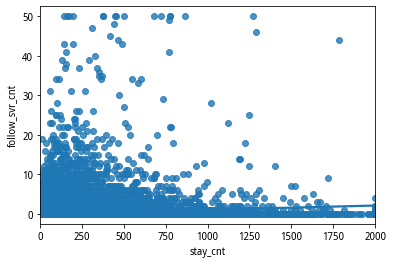

In [207]:
sns.regplot(new_new_df[numerical_col[0]],new_new_df[numerical_col[3]])

<AxesSubplot:xlabel='stay_cnt', ylabel='forward_cnt'>

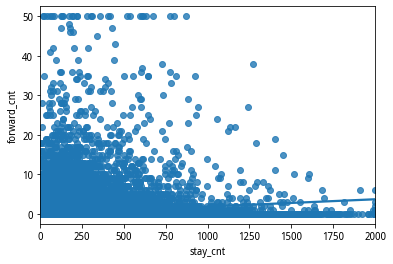

In [208]:
sns.regplot(new_new_df[numerical_col[0]],new_new_df[numerical_col[4]])

<AxesSubplot:xlabel='cold_start_stay_cnt', ylabel='like_svr_cnt'>

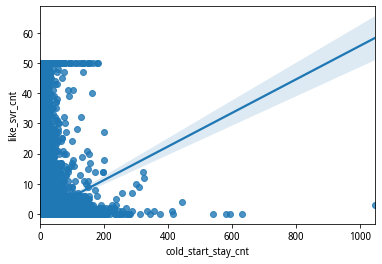

In [209]:
sns.regplot(new_new_df[numerical_col[1]],new_new_df[numerical_col[2]])

<AxesSubplot:xlabel='cold_start_stay_cnt', ylabel='follow_svr_cnt'>

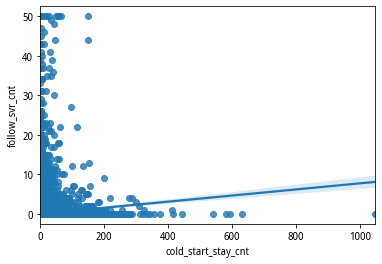

In [210]:
sns.regplot(new_new_df[numerical_col[1]],new_new_df[numerical_col[3]])

<AxesSubplot:xlabel='cold_start_stay_cnt', ylabel='forward_cnt'>

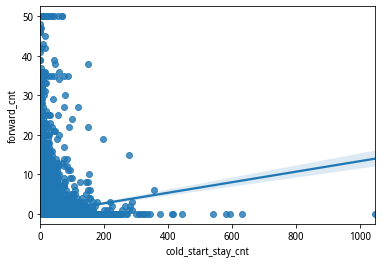

In [211]:
sns.regplot(new_new_df[numerical_col[1]],new_new_df[numerical_col[4]])

<AxesSubplot:xlabel='like_svr_cnt', ylabel='follow_svr_cnt'>

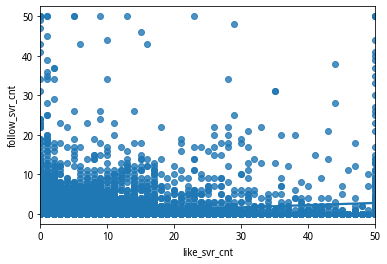

In [212]:
sns.regplot(new_new_df[numerical_col[2]],new_new_df[numerical_col[3]])

<AxesSubplot:xlabel='like_svr_cnt', ylabel='forward_cnt'>

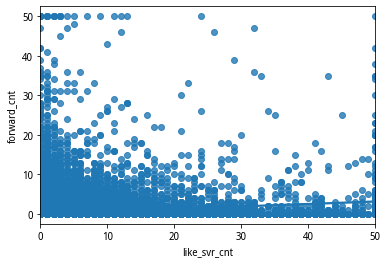

In [213]:
sns.regplot(new_new_df[numerical_col[2]],new_new_df[numerical_col[4]])

<AxesSubplot:xlabel='follow_svr_cnt', ylabel='forward_cnt'>

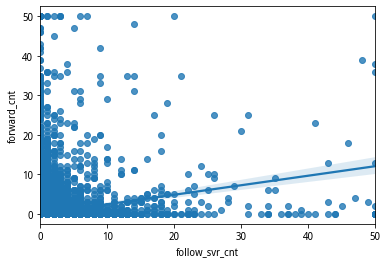

In [214]:
sns.regplot(new_new_df[numerical_col[3]],new_new_df[numerical_col[4]])

In [216]:
# (2)Categorical/Numerical
# categorical = 看下日期和分组，分别的对不同nmuerical的影响
# # statistics--计算下ATE和p值
# 按照日期(一共有三天)
np.round(new_new_df.groupby(new_new_df["ds"]).mean(),3)

,groupid,first_hit_ds,is_active_today,stay_cnt,like_svr_cnt,follow_svr_cnt,forward_cnt,cold_start_stay_cnt,in_experiment
ds,,,,,,,,,
20220717,309153.5,2.022071e+07,0.275,12.433,0.153,0.018,0.035,0.297,1.0
20220718,309153.5,2.022071e+07,0.272,11.855,0.147,0.017,0.033,0.315,1.0


In [219]:
# 按照分组
np.round(new_new_df.groupby(new_new_df["groupid"]).mean(),3)

,first_hit_ds,is_active_today,stay_cnt,like_svr_cnt,follow_svr_cnt,forward_cnt,cold_start_stay_cnt,in_experiment
groupid,,,,,,,,
309153,2.022071e+07,0.274,12.072,0.149,0.018,0.034,0.305,1.0
309154,2.022071e+07,0.274,12.206,0.151,0.018,0.034,0.307,1.0


In [222]:
# 按照分组
new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"]]).mean()

first_hit_ds  is_active_today   stay_cnt  like_svr_cnt  \
groupid ds                                                                 
309153  20220717  2.022071e+07         0.274444  12.401724      0.153522   
        20220718  2.022071e+07         0.272725  11.753939      0.145408   
309154  20220717  2.022071e+07         0.275532  12.464878      0.153002   
        20220718  2.022071e+07         0.272003  11.955316      0.149220   

                  follow_svr_cnt  forward_cnt  cold_start_stay_cnt  \
groupid ds                                                           
309153  20220717        0.018271     0.034627             0.298721   
        20220718        0.017406     0.032494             0.311666   
309154  20220717        0.017696     0.034403             0.296170   
        20220718        0.017333     0.034040             0.318109   

                  in_experiment  
groupid ds                       
309153  20220717            1.0  
        20220718            1.0  
309154  20220717            1.0  
        20220718            1.0

In [230]:
# 按照分组
treatment_effect= np.round(new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"],new_new_df["is_active_today"]]).mean(),3)
treatment_effect.to_excel("treatment_effect.xls")

In [231]:
treatment_effect

first_hit_ds  stay_cnt  like_svr_cnt  \
groupid ds       is_active_today                                         
309153  20220717 0                2.022071e+07     0.111         0.003   
                 1                2.022071e+07    44.894         0.551   
        20220718 0                2.022071e+07     0.120         0.003   
                 1                2.022071e+07    42.779         0.524   
309154  20220717 0                2.022071e+07     0.115         0.003   
                 1                2.022071e+07    44.938         0.547   
        20220718 0                2.022071e+07     0.111         0.003   
                 1                2.022071e+07    43.657         0.541   

                                  follow_svr_cnt  forward_cnt  \
groupid ds       is_active_today                                
309153  20220717 0                         0.000        0.001   
                 1                         0.066        0.125   
        20220718 0                         0.000        0.000   
                 1                         0.063        0.118   
309154  20220717 0                         0.000        0.000   
                 1                         0.064        0.124   
        20220718 0                         0.000        0.000   
                 1                         0.063        0.124   

                                  cold_start_stay_cnt  in_experiment  
groupid ds       is_active_today                                      
309153  20220717 0                              0.002            1.0  
                 1                              1.084            1.0  
        20220718 0                              0.002            1.0  
                 1                              1.137            1.0  
309154  20220717 0                              0.002            1.0  
                 1                              1.070            1.0  
        20220718 0                              0.001            1.0  
                 1                              1.166            1.0

In [235]:
# 计算P值
for col in numerical_col:
    content_c=(new_new_df.where(new_new_df.groupid==309153)[col].dropna()).tolist()
    count_c=[1 for _ in range(len(content_c))]
    content_t2=(new_new_df.where(new_new_df.groupid==309154)[col].dropna()).tolist()
    count_t2=[1 for _ in range(len(content_t2))]
    M_c=Metric(content_c,count_c)
    M_t=Metric(content_t2,count_t2)
    p= Ttest(M_c,M_t).pvalue()
    print(col,p)

stay_cnt 0.10947462409300446
cold_start_stay_cnt 0.7237862273125308
like_svr_cnt 0.42533460468059703
follow_svr_cnt 0.5482924716112074
forward_cnt 0.3788221199967756


In [238]:
# 计算ctr
sum_value= new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"],new_new_df["is_active_today"]]).sum()
sum_value.to_excel("sum_value.xls")

In [239]:
sum_value

first_hit_ds   stay_cnt  like_svr_cnt  \
groupid ds       is_active_today                                           
309153  20220717 0                6267328112726    34508.0        1001.0   
                 1                2370635428650  5263310.0       64581.0   
        20220718 0                6495458252851    38473.0        1055.0   
                 1                2435766347176  5153089.0       63170.0   
309154  20220717 0                6264153458536    35553.0         953.0   
                 1                2382403882631  5294541.0       64472.0   
        20220718 0                6507105378938    35617.0         973.0   
                 1                2431257129256  5249111.0       64988.0   

                                  follow_svr_cnt  forward_cnt  \
groupid ds       is_active_today                                
309153  20220717 0                          81.0        155.0   
                 1                        7724.0      14637.0   
        20220718 0                          75.0        102.0   
                 1                        7613.0      14250.0   
309154  20220717 0                          55.0        114.0   
                 1                        7512.0      14597.0   
        20220718 0                          80.0        137.0   
                 1                        7582.0      14910.0   

                                  cold_start_stay_cnt  in_experiment  
groupid ds       is_active_today                                      
309153  20220717 0                              490.0         309946  
                 1                           127119.0         117238  
        20220718 0                              665.0         321228  
                 1                           136994.0         120459  
309154  20220717 0                              603.0         309789  
                 1                           126042.0         117820  
        20220718 0                              467.0         321804  
                 1                           140150.0         120236

In [237]:
# 计算ctr的p值
content_c=(new_new_df.where(new_new_df.groupid==309153)["like_svr_cnt"].dropna()).tolist()
count_c=(new_new_df.where(new_new_df.groupid==309153)["stay_cnt"].dropna()).tolist()
content_t2=(new_new_df.where(new_new_df.groupid==309154)["like_svr_cnt"].dropna()).tolist()
count_t2=(new_new_df.where(new_new_df.groupid==309154)["stay_cnt"].dropna()).tolist()
M_c=Metric(content_c,count_c)
M_t=Metric(content_t2,count_t2)
p= Ttest(M_c,M_t).pvalue()
print("ctr",p)

ctr 0.9882919484746178


#### visualization

In [ ]:
# groupid

<AxesSubplot:xlabel='stay_cnt', ylabel='like_svr_cnt'>

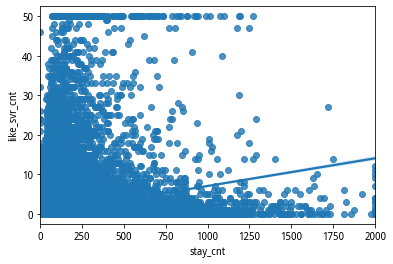

In [229]:
sns.regplot(new_new_df.loc[new_new_df["groupid"]==309153]["stay_cnt"],new_new_df.loc[new_new_df["groupid"]==309153]["like_svr_cnt"])


<AxesSubplot:xlabel='stay_cnt', ylabel='like_svr_cnt'>

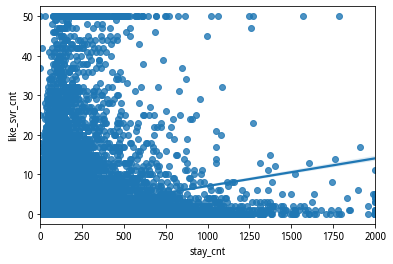

In [232]:
sns.regplot(new_new_df.loc[new_new_df["groupid"]==309154]["stay_cnt"],new_new_df.loc[new_new_df["groupid"]==309154]["like_svr_cnt"])

In [ ]:
# is_active_today

<AxesSubplot:xlabel='stay_cnt', ylabel='like_svr_cnt'>

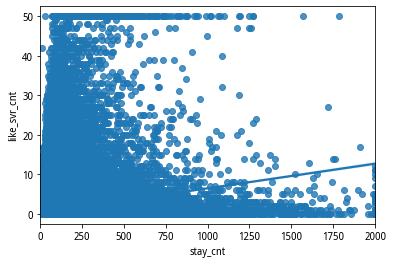

In [234]:
sns.regplot(new_new_df.loc[new_new_df["is_active_today"]==1]["stay_cnt"],new_new_df.loc[new_new_df["is_active_today"]==1]["like_svr_cnt"])

<AxesSubplot:xlabel='stay_cnt', ylabel='like_svr_cnt'>

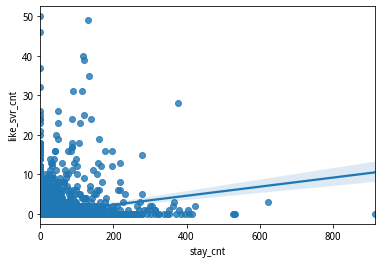

In [233]:
sns.regplot(new_new_df.loc[new_new_df["is_active_today"]==0]["stay_cnt"],new_new_df.loc[new_new_df["is_active_today"]==0]["like_svr_cnt"])

<AxesSubplot:xlabel='stay_cnt', ylabel='cold_start_stay_cnt'>

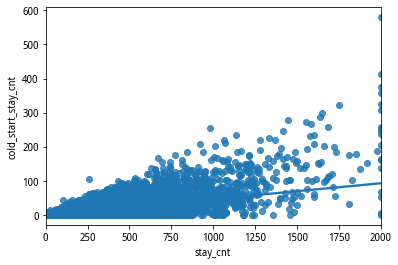

In [240]:
sns.regplot(new_new_df.loc[new_new_df["groupid"]==309153]["stay_cnt"],new_new_df.loc[new_new_df["groupid"]==309153]["cold_start_stay_cnt"])

<AxesSubplot:xlabel='stay_cnt', ylabel='cold_start_stay_cnt'>

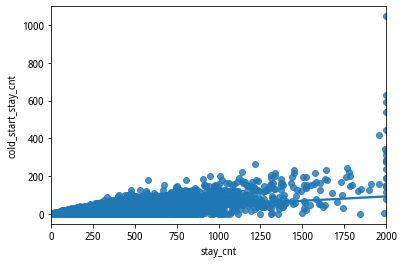

In [241]:
sns.regplot(new_new_df.loc[new_new_df["groupid"]==309154]["stay_cnt"],new_new_df.loc[new_new_df["groupid"]==309154]["cold_start_stay_cnt"])

<AxesSubplot:xlabel='stay_cnt', ylabel='cold_start_stay_cnt'>

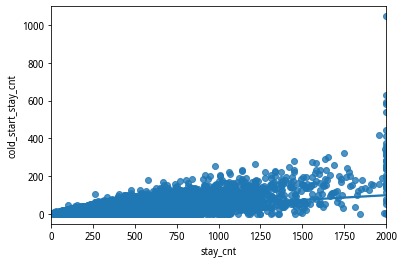

In [242]:
sns.regplot(new_new_df.loc[new_new_df["is_active_today"]==1]["stay_cnt"],new_new_df.loc[new_new_df["is_active_today"]==1]["cold_start_stay_cnt"])

<AxesSubplot:xlabel='stay_cnt', ylabel='cold_start_stay_cnt'>

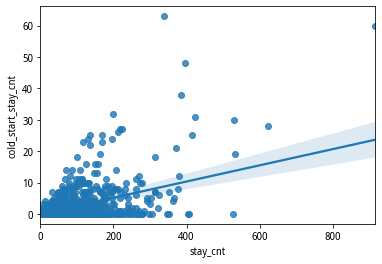

In [243]:
sns.regplot(new_new_df.loc[new_new_df["is_active_today"]==0]["stay_cnt"],new_new_df.loc[new_new_df["is_active_today"]==0]["cold_start_stay_cnt"])

<AxesSubplot:xlabel='groupid', ylabel='stay_cnt'>

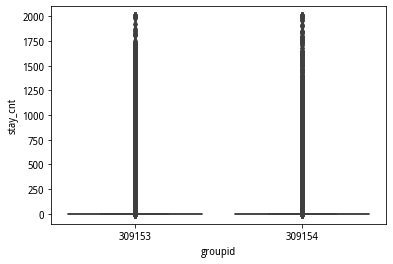

In [30]:
# # Visualization --箱线图
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["stay_cnt"])

<AxesSubplot:xlabel='is_active_today', ylabel='stay_cnt'>

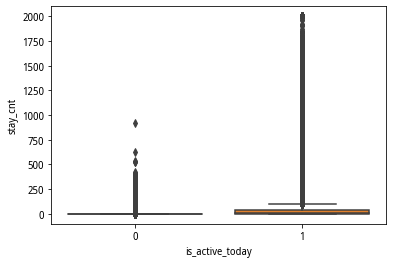

In [31]:
sns.boxplot(x=new_new_df["is_active_today"],y=new_new_df["stay_cnt"])